In [2]:
import zipfile
import os
import shutil
from pathlib import Path
import torch
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as T
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from torch.utils.data import Subset
import matplotlib.pyplot as plt
from torch.utils.data import WeightedRandomSampler
from collections import Counter
import time
import torch.optim as optim
import numpy as np
import torch.nn as nn
import torch.nn.functional as F

In [3]:
# Extracting the images from ZipFile
path_to_file = '/content/drive/MyDrive/FaceExpressions'
EXTRACT_DATA_DIR = "inputimageFiles"

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
print(os.listdir(path_to_file))
print(os.listdir(path_to_file + "/dataset/"))

['data.csv', 'dataset']
['Angry', 'Neutral', 'Sad', 'Happy', 'Surprise']


In [6]:
print(os.listdir(path_to_file + "/dataset/"))
DATA_DIR = path_to_file + "/dataset/"

['Angry', 'Neutral', 'Sad', 'Happy', 'Surprise']


In [7]:
# Create a dataset using the ImageFolder utility
full_dataset = ImageFolder(DATA_DIR)

# Count the number of images per class
class_counts = {}
for _, label in full_dataset.samples:
    class_name = full_dataset.classes[label]
    class_counts[class_name] = class_counts.get(class_name, 0) + 1

print(class_counts)

{'Angry': 1339, 'Happy': 3793, 'Neutral': 4084, 'Sad': 3969, 'Surprise': 1234}


In [8]:
# Defining the transformations, including conversion to tensor
transform_augmentation = transforms.Compose([
    transforms.Resize((64,64)),  # Resize the image to 64x64
    transforms.RandomHorizontalFlip(),  # Randomly flip the images horizontally
    transforms.RandomRotation(10),      # Random rotation between -10 to 10 degrees
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),  # Random color jitter
    transforms.ToTensor(),  # Convert the PIL Image to a tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Normalize the tensor
])

# Apply the transform to our ImageFolder dataset
full_dataset = ImageFolder(DATA_DIR, transform=transform_augmentation)

In [9]:
# Obtaining the targets from the dataset
targets = [label for _, label in full_dataset.samples]

# Splitting the dataset while stratifying to preserve class distribution
train_idx, test_idx = train_test_split(
    list(range(len(targets))),
    test_size=0.2,
    random_state=42,
    stratify=targets
)

In [10]:
# Using Subset to create datasets for training and testing
train_dataset = Subset(full_dataset, train_idx)
test_dataset = Subset(full_dataset, test_idx)

In [11]:
# Count the number of occurrences of each label in the training set
label_count = Counter([targets[i] for i in train_idx])

# Create a weight for each sample in the training set
weights = [1.0 / label_count[targets[i]] for i in train_idx]

# Create the sampler
sampler = WeightedRandomSampler(weights, num_samples=len(weights), replacement=True)

# Create the DataLoader for training
train_loader = DataLoader(train_dataset, batch_size=64, sampler=sampler)

In [12]:
# To check the distribution over several batches from the train_loader
class_distribution_in_batches = Counter()

for images, labels in train_loader:
    class_distribution_in_batches.update(labels.numpy())

print(class_distribution_in_batches)

Counter({1: 2364, 4: 2307, 3: 2300, 0: 2298, 2: 2266})


In [13]:
class FaceExpressionCNN(nn.Module):
    def __init__(self):
        super(FaceExpressionCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(128 * 8 * 8, 256)  # Adjust size based on your image dimension
        self.fc2 = nn.Linear(256, len(full_dataset.classes))

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv3(x))
        x = F.max_pool2d(x, 2)
        x = x.view(-1, 128 * 8 * 8)  # Flatten the tensor for the fully connected layer
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [14]:
# Initialize the model, loss function, and optimizer
model = FaceExpressionCNN()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


In [15]:
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [16]:
# Prepare for training and evaluation
num_epochs = 10
start_time = time.time()

train_accuracies = []
test_accuracies = []
losses = []

for epoch in range(num_epochs):
    model.train()  # Set model to training mode
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    # Training loop
    for images, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        correct_train += (predicted == labels).sum().item()
        total_train += labels.size(0)

    train_accuracy = 100 * correct_train / total_train
    train_accuracies.append(train_accuracy)
    losses.append(running_loss / len(train_loader))

    # Validation loop
    model.eval()  # Set model to evaluation mode
    correct_test = 0
    total_test = 0
    with torch.no_grad():
        for images, labels in test_loader:
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            correct_test += (predicted == labels).sum().item()
            total_test += labels.size(0)

    test_accuracy = 100 * correct_test / total_test
    test_accuracies.append(test_accuracy)

    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader):.4f}, Train Acc: {train_accuracy:.2f}%, Test Acc: {test_accuracy:.2f}%')

end_time = time.time()
print(f'Training time: {end_time - start_time} seconds')

Epoch 1/10, Loss: 1.3885, Train Acc: 39.60%, Test Acc: 47.19%
Epoch 2/10, Loss: 1.0855, Train Acc: 57.83%, Test Acc: 54.54%
Epoch 3/10, Loss: 0.9185, Train Acc: 63.84%, Test Acc: 59.99%
Epoch 4/10, Loss: 0.8370, Train Acc: 67.56%, Test Acc: 60.61%
Epoch 5/10, Loss: 0.7895, Train Acc: 68.83%, Test Acc: 60.78%
Epoch 6/10, Loss: 0.7264, Train Acc: 71.37%, Test Acc: 62.90%
Epoch 7/10, Loss: 0.6710, Train Acc: 73.33%, Test Acc: 64.91%
Epoch 8/10, Loss: 0.6360, Train Acc: 74.93%, Test Acc: 65.53%
Epoch 9/10, Loss: 0.5973, Train Acc: 76.02%, Test Acc: 66.26%
Epoch 10/10, Loss: 0.5690, Train Acc: 77.16%, Test Acc: 64.56%
Training time: 5415.826303243637 seconds


In [17]:
# Evaluation for confusion matrix and AUC score
all_labels = []
all_predictions = []

for images, labels in test_loader:
    outputs = model(images)
    _, predicted = torch.max(outputs, 1)
    all_labels.extend(labels.tolist())  # Convert labels to list and extend the existing list
    all_predictions.extend(predicted.tolist())  # Convert predictions to list and extend the existing list

In [18]:
# calculating the confusion matrix and AUC score using the accumulated labels and predictions
conf_matrix = confusion_matrix(all_labels, all_predictions)
print("Confusion Matrix:")
print(conf_matrix)

Confusion Matrix:
[[188  16  11  34  19]
 [ 10 666  10  46  26]
 [ 80  68 325 277  67]
 [ 74  79  94 486  61]
 [  6  19  12  15 195]]


In [19]:
# Before calculating AUC, we need to convert the predictions to a one-hot encoded format
from sklearn.preprocessing import label_binarize
all_labels_binarized = label_binarize(all_labels, classes=range(len(full_dataset.classes)))
all_predictions_binarized = label_binarize(all_predictions, classes=range(len(full_dataset.classes)))

auc_score = roc_auc_score(all_labels_binarized, all_predictions_binarized, multi_class='ovr', average='macro')
print(f'AUC Score: {auc_score}')

AUC Score: 0.7923853217250716


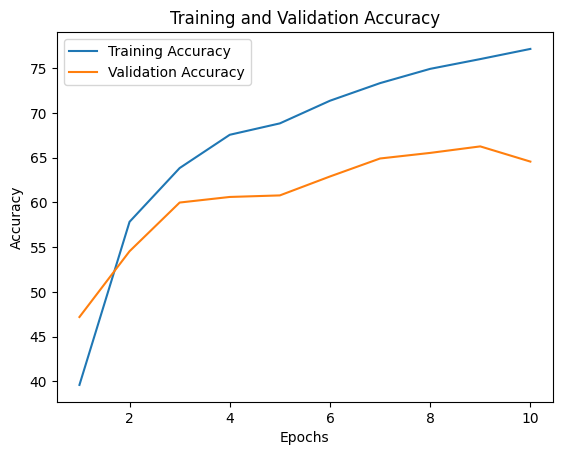

In [20]:
# Plotting the training and validation accuracies
plt.plot(range(1, num_epochs + 1), train_accuracies, label='Training Accuracy')
plt.plot(range(1, num_epochs + 1), test_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

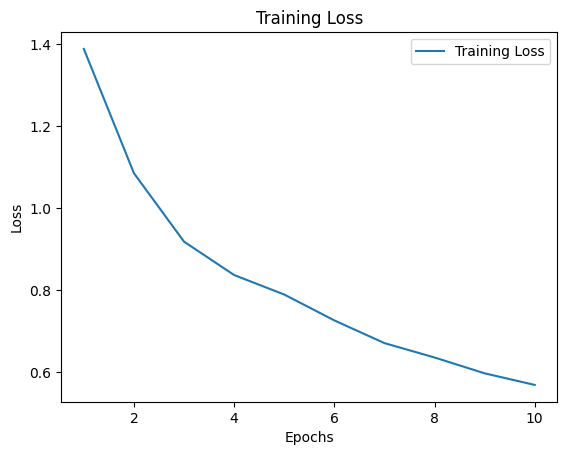

In [21]:
# Plotting the losses
plt.plot(range(1, num_epochs + 1), losses, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()
plt.show()

In [22]:
#Emperical Tuning


transform_augmentation = transforms.Compose([
    transforms.Resize((64,64)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1)),
    transforms.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
# Apply the transform to our ImageFolder dataset
full_dataset = ImageFolder(DATA_DIR, transform=transform_augmentation)

In [23]:
targets = [label for _, label in full_dataset.samples]
train_idx, test_idx = train_test_split(
    list(range(len(targets))),
    test_size=0.2,
    random_state=42,
    stratify=targets
)

In [24]:
# Using Subset to create datasets for training and testing
train_dataset = Subset(full_dataset, train_idx)
test_dataset = Subset(full_dataset, test_idx)

In [25]:
# Count the number of occurrences of each label in the training set
label_count = Counter([targets[i] for i in train_idx])

# Create a weight for each sample in the training set
weights = [1.0 / label_count[targets[i]] for i in train_idx]

# Create the sampler
sampler = WeightedRandomSampler(weights, num_samples=len(weights), replacement=True)

In [26]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)
train_loader = DataLoader(train_dataset, batch_size=32, sampler=sampler)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [27]:
class FaceExpressionCNN(nn.Module):
    def __init__(self):
        super(FaceExpressionCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.drop = nn.Dropout(0.5)  # Dropout layer
        self.fc1 = nn.Linear(128 * 8 * 8, 256)
        self.fc2 = nn.Linear(256, len(full_dataset.classes))

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = self.drop(x)  # Apply dropout
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = self.drop(x)  # Apply dropout
        x = F.relu(self.conv3(x))
        x = F.max_pool2d(x, 2)
        x = x.view(-1, 128 * 8 * 8)  # Flatten the tensor
        x = F.relu(self.fc1(x))
        x = self.drop(x)  # Apply dropout before final layer
        x = self.fc2(x)
        return x

In [28]:
model = FaceExpressionCNN()

In [29]:
# Loss function and optimizer with a new learning rate
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)

# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for images, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        correct_train += (predicted == labels).sum().item()
        total_train += labels.size(0)

    train_accuracy = 100 * correct_train / total_train

    # Validation loop
    model.eval()
    correct_test = 0
    total_test = 0
    with torch.no_grad():
        for images, labels in test_loader:
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            correct_test += (predicted == labels).sum().item()
            total_test += labels.size(0)

    test_accuracy = 100 * correct_test / total_test

    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader):.4f}, '
          f'Train Acc: {train_accuracy:.2f}%, Test Acc: {test_accuracy:.2f}%')

Epoch 1/10, Loss: 1.5657, Train Acc: 29.48%, Test Acc: 29.79%
Epoch 2/10, Loss: 1.4979, Train Acc: 33.91%, Test Acc: 34.33%
Epoch 3/10, Loss: 1.4477, Train Acc: 37.93%, Test Acc: 34.95%
Epoch 4/10, Loss: 1.4161, Train Acc: 39.38%, Test Acc: 36.72%
Epoch 5/10, Loss: 1.3882, Train Acc: 41.74%, Test Acc: 38.56%
Epoch 6/10, Loss: 1.3518, Train Acc: 43.37%, Test Acc: 38.56%
Epoch 7/10, Loss: 1.3396, Train Acc: 44.69%, Test Acc: 42.16%
Epoch 8/10, Loss: 1.3130, Train Acc: 45.50%, Test Acc: 42.16%
Epoch 9/10, Loss: 1.3199, Train Acc: 45.62%, Test Acc: 46.01%
Epoch 10/10, Loss: 1.2933, Train Acc: 46.71%, Test Acc: 43.55%


In [30]:
end_time = time.time()
print(f'Training time: {end_time - start_time} seconds')

Training time: 9102.218125343323 seconds


In [31]:
# Evaluation for confusion matrix and AUC score
all_labels = []
all_predictions = []

for images, labels in test_loader:
    outputs = model(images)
    _, predicted = torch.max(outputs, 1)
    all_labels.extend(labels.tolist())  # Convert labels to list and extend the existing list
    all_predictions.extend(predicted.tolist())  # Convert predictions to list and extend the existing list

In [32]:
# calculating the confusion matrix and AUC score using the accumulated labels and predictions
conf_matrix = confusion_matrix(all_labels, all_predictions)
print("Confusion Matrix:")
print(conf_matrix)

Confusion Matrix:
[[185  26  20  10  27]
 [109 477  62  47  63]
 [242 141 275 101  58]
 [266 141 163 135  89]
 [ 67  22  12   9 137]]


In [33]:
# Before calculating AUC, we need to convert the predictions to a one-hot encoded format
from sklearn.preprocessing import label_binarize
all_labels_binarized = label_binarize(all_labels, classes=range(len(full_dataset.classes)))
all_predictions_binarized = label_binarize(all_predictions, classes=range(len(full_dataset.classes)))

auc_score = roc_auc_score(all_labels_binarized, all_predictions_binarized, multi_class='ovr', average='macro')
print(f'AUC Score: {auc_score}')

AUC Score: 0.6670061561921099


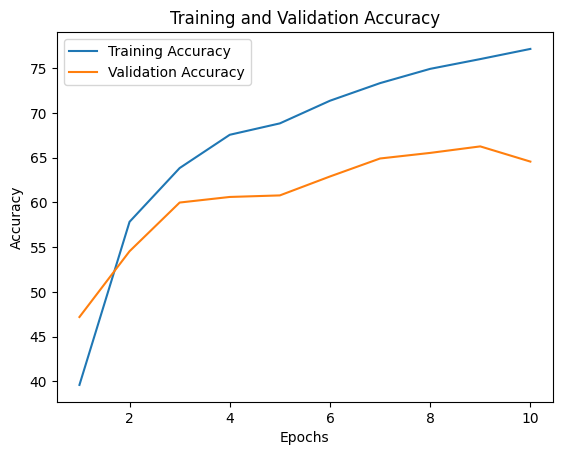

In [34]:
# Plotting the training and validation accuracies
plt.plot(range(1, num_epochs + 1), train_accuracies, label='Training Accuracy')
plt.plot(range(1, num_epochs + 1), test_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

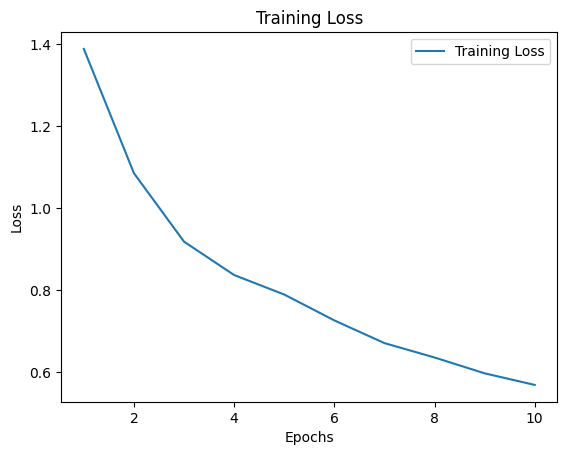

In [35]:
# Plotting the losses
plt.plot(range(1, num_epochs + 1), losses, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()
plt.show()

In [42]:
# Define the file path to save the model
model_path = '/content/drive/MyDrive/FaceExpressions/model.hdf5'

In [43]:
# Save the model
torch.save(model.state_dict(), model_path)

In [40]:
# Load the saved model
model.load_state_dict(torch.load(model_path))

<All keys matched successfully>

In [41]:
!pip install streamlit

ERROR: Operation cancelled by user


In [ ]:
import streamlit as st
import torch
from torchvision.utils import make_grid
import numpy as np
from PIL import Image

# Function to generate images using the specified model
def generate_images(generator, num_images, latent_size):
    # Generate latent vectors
    latent_vectors = torch.randn(num_images, latent_size, 1, 1)
    # Generate images
    with torch.no_grad():
        generated_images = generator(latent_vectors)
    return generated_images

# Dictionary to map expressions to corresponding model paths
expression_to_model = {
    'model': '/content/drive/MyDrive/FaceExpressions/model.pth',
}


# Streamlit app
st.title("Image Generation")

# Dropdown to select expression
expression = st.selectbox("Select Expression", options=['Angry', 'Happy', 'Neutral', 'Sad', 'Surprise'])

# Load the selected model
@st.cache_resource
def load_model(expression):
    model_path = expression_to_model[expression]
    return torch.load(model_path, map_location=torch.device('cpu'))  # Load the model

# Load model
model = load_model(expression)

# Specify number of images to generate
num_images = st.number_input("Number of Images to Generate", value=1)

# Generate and display images
if st.button("Generate Images"):
    latent_size = 128  # Assuming latent size is 100
    generated_images = generate_images(model, num_images, latent_size)
    # Create a grid of generated images
    grid = make_grid(generated_images, nrow=4, normalize=True)
    # Convert tensor to PIL Image
    image = Image.fromarray(grid.mul(255).clamp(0, 255).byte().permute(1, 2, 0).cpu().numpy())
    st.image(image, caption=f"Generated {num_images} images", use_column_width=True)